In [1]:
import bioMass.dataViz as dv
from bioMass.dataloader import SentinelDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
from torch import nn

%config Completer.use_jedi = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# https://pytorch.org/docs/master/notes/mps.html

if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loader_device = torch.device('cpu')  # found that using cpu for data loading was faster than gpu (for my device)
print(f'training device: {device}')
print(f'loader_device: {loader_device}')

training device: cuda
loader_device: cpu


In [3]:
dir_tiles = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/'
dir_target = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_agbm/'
dir_saved_models = '/home/ubuntu/Thesis/backup_data/bioMass_data/trained_models/'

In [14]:
max_chips = 100 # number of chips to use from training set, None = Use All  

# A custom dataloader for Sentinel data 
dataset = SentinelDataset(dir_tiles=dir_tiles, dir_target=dir_target,
                          max_chips=max_chips, transform=None,
                          device=loader_device
                         )

In [15]:
torch.manual_seed(0)

train_frac = 0.7
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_frac, 1-train_frac-0.1, 0.1])
print(f'N training samples: {len(train_dataset)}')

N training samples: 70


In [16]:
batch_size = 32  # Note: training speed is sensitive to memory usage
                 # set this as high as you can without significantly slowing down training time 
num_workers = 1
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True
                           )

test_dataloader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True
                           )

In [17]:
for sample in train_dataloader:
    image, target = sample['image_s2'].numpy(), sample['label'].numpy()
    break

(array([1.135951e+06, 4.889710e+05, 2.658830e+05, 1.205720e+05,
        5.406800e+04, 2.223400e+04, 6.966000e+03, 1.565000e+03,
        3.000000e+02, 6.420000e+02]),
 array([  0.        ,  58.38100052, 116.76200104, 175.14300537,
        233.52400208, 291.90499878, 350.28601074, 408.66699219,
        467.04800415, 525.42901611, 583.80999756]),
 <BarContainer object of 10 artists>)

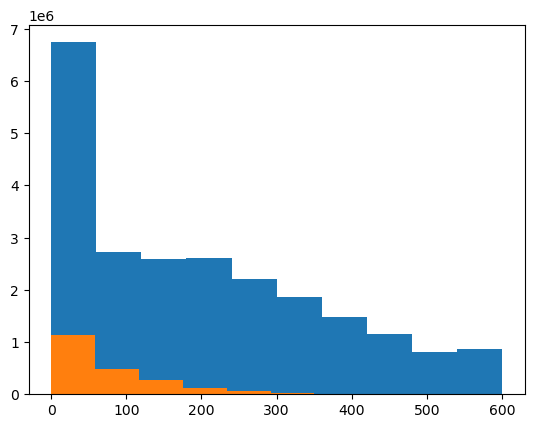

In [18]:
plt.hist(image.flatten())
plt.hist(target.flatten())

In [8]:
from bioMass.model import S2_Unet_pytorch, S2_Unet

In [9]:
sample['image_s2'].shape

torch.Size([32, 11, 256, 256])

In [10]:
model = S2_Unet_pytorch(64, 11, 0.5)

out = model(sample['image_s2']).shape
out

torch.Size([32, 1, 256, 256])

In [11]:
model = S2_Unet(64, 11, 0.5)

out = model(sample['image_s2']).shape
out

TypeError: __init__() missing 2 required positional arguments: 'in_channels' and 'dropout_p'

In [23]:
import segmentation_models_pytorch as smp

in_channels = train_dataset[0]['image_s2'].shape[0]
print(f'# input channels: {in_channels}')

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
    in_channels=in_channels,                 
    classes=1,                     
)

# input channels: 11


In [24]:
model(sample['image_s2']).shape

torch.Size([32, 1, 256, 256])